Group assignment: Second-level & ROI analysis
===

Dataset: *Entorhinal grid-like codes and time-locked network dynamics track others navigating through space (Wagner et al., 2022)*

# 0. Setup

## Imports

In [103]:
from nipype import config
import os
from os.path import join as opj, abspath
import numpy as np
import pandas as pd
from nilearn import datasets, plotting, image, surface
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.maskers import NiftiMapsMasker
from nilearn.image import resample_to_img
import re
from nltools.mask import create_sphere
from pprint import pprint
import pickle
import warnings

warnings.simplefilter("ignore", UserWarning)

template = datasets.load_mni152_template(resolution=1)

config.update_config(
    {
        "logging": {"workflow_level": "INFO"},
        "execution": {
            "stop_on_first_crash": "True",
            "hash_method": "content",
            "remove_unnecessary_outputs": "True",
        },
    }
)

contrast_dir_dict = {
    "navigation > baseline * cumulative distance error (vm)": "navigation",
    "obervation > baseline * cumulative distance error (vm)": "other",
    "observation > navigation": "other-self",
    "?": "self",
    "navigation > observation": "self-other",
}

# Check if ENV variables are set
print("'FSLDIR':", os.environ["FSLDIR"])
print("'FSLOUTPUTTYPE':", os.environ["FSLOUTPUTTYPE"])

fslpath = os.environ["FSLDIR"]

'FSLDIR': /opt/fsl-5.0.11
'FSLOUTPUTTYPE': NIFTI


## Download data

In [27]:
data_dir = "data_Wagner_NatComms_2022"
data_url = "https://ucloud.univie.ac.at/index.php/s/lxNhTQJ4TbkaLnh/download"

if os.path.exists(data_dir) == False:
    print("Downloading data ...", end="")
    import requests
    from zipfile import ZipFile

    r = requests.get(data_url)
    open("data.zip", "wb").write(r.content)
    print("completed.")
    print("Unzipping data ...", end="")
    with ZipFile("data.zip", "r") as zo:
        zo.extractall()
    zo.close()
    print("completed.")
    print("Removing zipfile ...", end="")
    os.remove("data.zip")
    print("completed.")

else:
    print("Data already downloaded.")

Unzipping data ...completed.
Removing zipfile ...completed.


# Second-level analysis

## **A**) Model for `other > self`

### Define data and distance matrix

In [28]:
chosen_contrast = "observation > navigation"


cmaps_dir = (
    data_dir
    + "/model_m1_contrasts_swratopup/"
    + contrast_dir_dict[chosen_contrast]
    + "-AllSessions"
)

print(f"data is stored in: {abspath(cmaps_dir)}")

cmaps = sorted(
    glob(
        f"{abspath(cmaps_dir)}/**/*.nii",
        recursive=True,
    )
)

# pprint(cmaps)
print(f"\nThere are {len(cmaps)} contrast maps")

n_subjects = len(cmaps)
subject_list = [f"sub-{i:02d}" for i in range(1, n_subjects + 1)]

# Intercept-only model, no groups, no 2nd level contrasts
design_matrix = pd.DataFrame(
    [1] * n_subjects, columns=["intercept"], index=subject_list
)

design_matrix.head()

data is stored in: /main/assignments/group/data_Wagner_NatComms_2022/model_m1_contrasts_swratopup/other-self-AllSessions

There are 59 contrast maps


,intercept
sub-01,1
sub-02,1
sub-03,1
sub-04,1
sub-05,1


In [30]:
second_level = SecondLevelModel(n_jobs=2)
second_level = second_level.fit(cmaps, design_matrix=design_matrix)

other_self = second_level.compute_contrast(
    second_level_contrast="intercept", output_type="stat", second_level_stat_type="t"
)

## Correcting multiple comparisons

<div class="alert alert-warning">Do we need the complete image with all the negative activations for calculating the threshold?</div>

### Thresholded map

In [31]:
thresholded_map, threshold = threshold_stats_img(
    other_self, alpha=0.001, height_control="fdr", cluster_threshold=91, two_sided=True
)

print(f"The FDR=.001 threshold is {round(threshold, 3)}")


thresholded_map_pos = image.new_img_like(
    thresholded_map, np.clip(thresholded_map.get_fdata(), 0, None)
)

# scale up resolution to template
thresholded_map_pos = resample_to_img(thresholded_map_pos, template)

The FDR=.001 threshold is 3.541


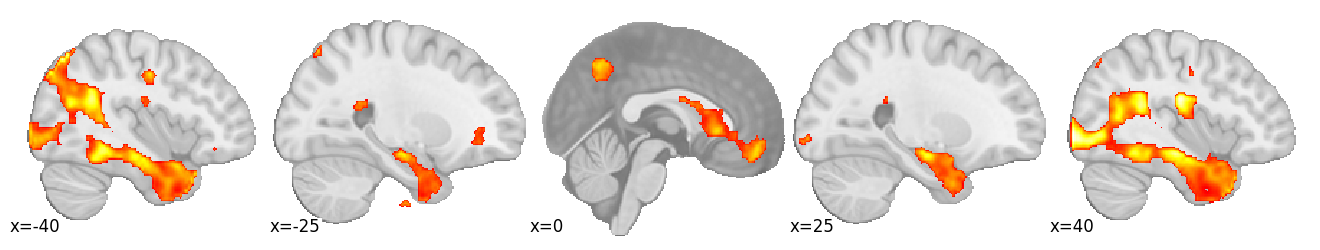

In [32]:
plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-40, -25, 0, 25, 40),
    display_mode="x",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
)

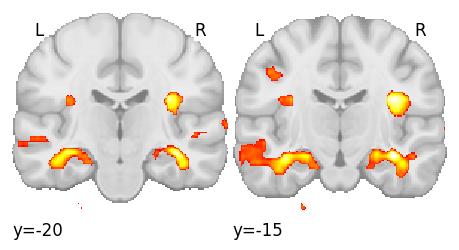

In [33]:
plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-20, -15),
    display_mode="y",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
)

## Surface plots

In [34]:
# for higher resolution
big_fsaverage = datasets.fetch_surf_fsaverage("fsaverage")
big_texture_r = surface.vol_to_surf(thresholded_map_pos, big_fsaverage.pial_right)
big_texture_l = surface.vol_to_surf(thresholded_map_pos, big_fsaverage.pial_left)


Dataset created in /root/nilearn_data/fsaverage



Downloaded 26173440 of 28905506 bytes (90.5%,    0.2s remaining) ...done. (4 seconds, 0 min)
Extracting data from /root/nilearn_data/fsaverage/5592d63c5c8039b4f902396c128dcd85/download..... done.


### Multiple views

with higher resolution (`surf_mesh` argument)

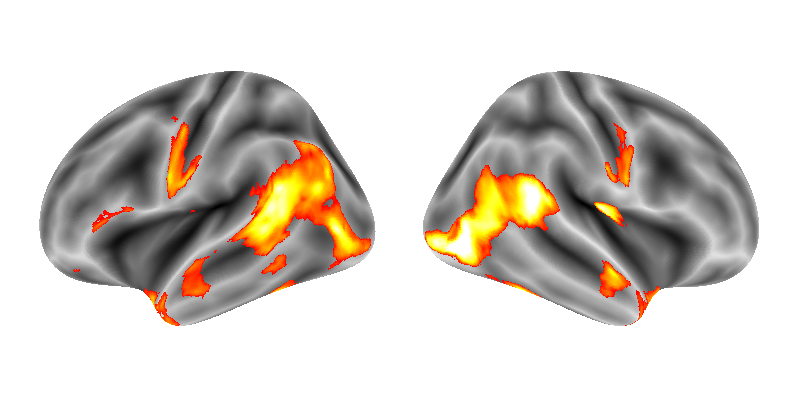

In [35]:
plotting.plot_img_on_surf(
    thresholded_map_pos,
    surf_mesh=big_fsaverage,
    views=["lateral"],
    hemispheres=["left", "right"],
    threshold=threshold,
    colorbar=False,
    inflate=True,
    vmax=10,
)
plotting.show()

## Multiplot figure

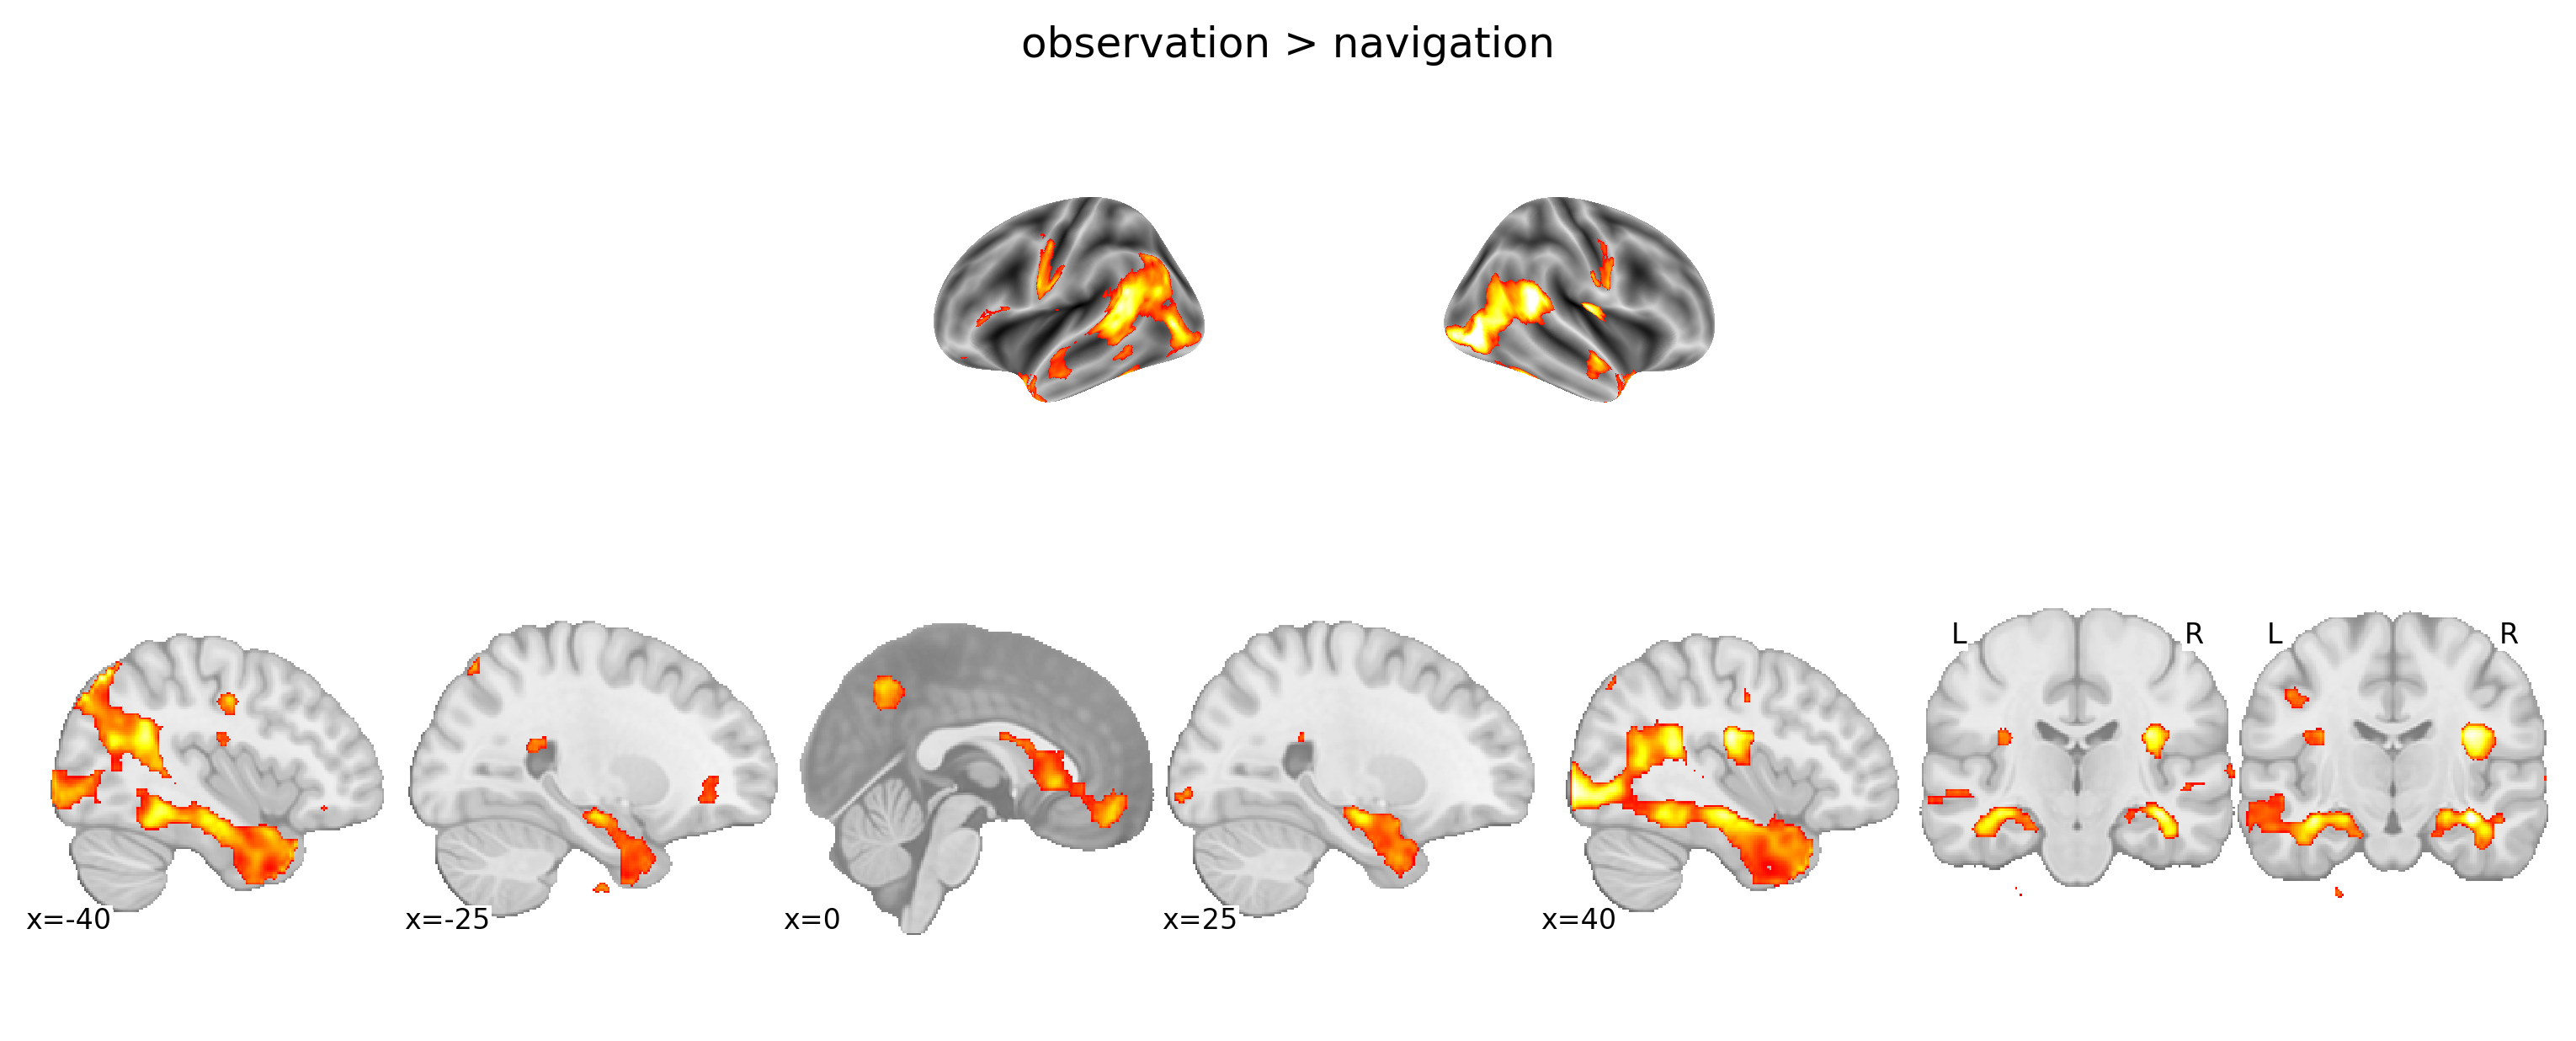

In [36]:
fig = plt.figure(figsize=(10, 4), dpi=300)
#  rc('font', size=8)

plot_upper_l = fig.add_subplot(2, 4, 2, projection="3d")

plotting.plot_surf_stat_map(
    big_fsaverage.infl_left,
    big_texture_l,
    hemi="left",
    view="lateral",
    colorbar=False,
    threshold=threshold,
    bg_map=big_fsaverage.sulc_left,
    vmax=10,
    figure=fig,
    axes=plot_upper_l,
)


plot_upper_r = fig.add_subplot(2, 4, 3, projection="3d")
plotting.plot_surf_stat_map(
    big_fsaverage.infl_right,
    big_texture_r,
    hemi="right",
    view="lateral",
    colorbar=False,
    threshold=threshold,
    bg_map=big_fsaverage.sulc_right,
    vmax=10,
    figure=fig,
    axes=plot_upper_r,
)


plot_left = plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-40, -25, 0, 25, 40),
    display_mode="x",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
    annotate=False,
    figure=fig,
    axes=(0, 0, 0.75, 0.48),  # axes = (xmin, ymin, width, height)
)

plot_left.annotate(left_right=False, positions=True, size=8, scale_loc="center")

plot_right = plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-20, -15),
    display_mode="y",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
    annotate=False,
    figure=fig,
    axes=(0.75, 0, 0.25, 0.48),
)

plot_right.annotate(left_right=True, positions=False, size=8, scale_loc="center")

fig.suptitle(chosen_contrast)

fig.savefig(f"multiplot_figure_obs_nav.png")

## **B**) Model for `self > other`

### Define data and distance matrix

In [163]:
chosen_contrast = "navigation > observation"


cmaps_dir = (
    data_dir
    + "/model_m1_contrasts_swratopup/"
    + contrast_dir_dict[chosen_contrast]
    + "-AllSessions"
)

print(f"data is stored in: {abspath(cmaps_dir)}")

cmaps = sorted(
    glob(
        f"{abspath(cmaps_dir)}/**/*.nii",
        recursive=True,
    )
)

# pprint(cmaps)
print(f"\nThere are {len(cmaps)} contrast maps")

n_subjects = len(cmaps)
subject_list = [f"sub-{i:02d}" for i in range(1, n_subjects + 1)]

# Intercept-only model, no groups, no 2nd level contrasts
design_matrix = pd.DataFrame(
    [1] * n_subjects, columns=["intercept"], index=subject_list
)

design_matrix.head()

data is stored in: /main/assignments/group/data_Wagner_NatComms_2022/model_m1_contrasts_swratopup/self-other-AllSessions

There are 59 contrast maps


,intercept
sub-01,1
sub-02,1
sub-03,1
sub-04,1
sub-05,1


In [164]:
second_level = SecondLevelModel(n_jobs=2)
second_level = second_level.fit(cmaps, design_matrix=design_matrix)

other_self = second_level.compute_contrast(
    second_level_contrast="intercept", output_type="stat", second_level_stat_type="t"
)

## Correcting multiple comparisons

<div class="alert alert-warning">Do we need the complete image with all the negative activations for calculating the threshold?</div>

### Thresholded map

In [165]:
thresholded_map, threshold = threshold_stats_img(
    other_self, alpha=0.001, height_control="fdr", cluster_threshold=91, two_sided=True
)

print(f"The FDR=.001 threshold is {round(threshold, 3)}")


thresholded_map_pos = image.new_img_like(
    thresholded_map, np.clip(thresholded_map.get_fdata(), 0, None)
)

# scale up resolution to template
thresholded_map_pos = resample_to_img(thresholded_map_pos, template)

The FDR=.001 threshold is 3.541


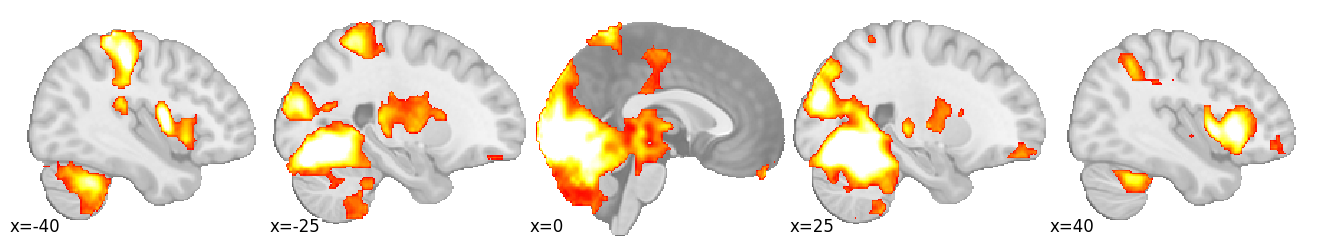

In [166]:
plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-40, -25, 0, 25, 40),
    display_mode="x",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
)

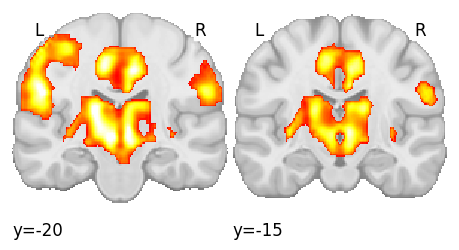

In [167]:
plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-20, -15),
    display_mode="y",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
)

## Surface plots

In [55]:
# for higher resolution
big_fsaverage = datasets.fetch_surf_fsaverage("fsaverage")
big_texture_r = surface.vol_to_surf(thresholded_map_pos, big_fsaverage.pial_right)
big_texture_l = surface.vol_to_surf(thresholded_map_pos, big_fsaverage.pial_left)

### Multiple views

with higher resolution (`surf_mesh` argument)

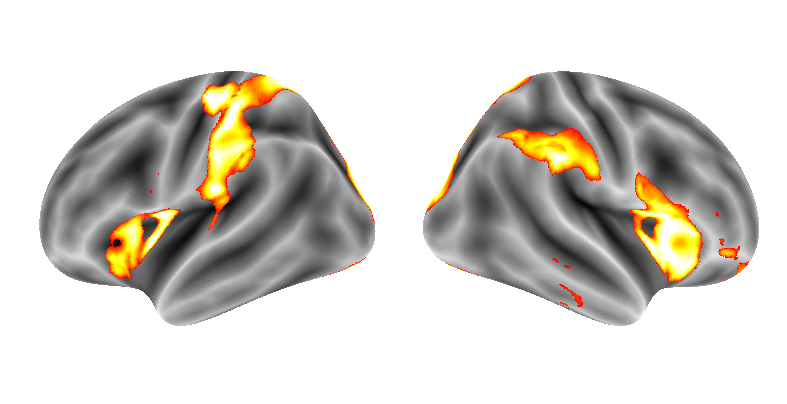

In [157]:
fig, ax = plotting.plot_img_on_surf(
    thresholded_map_pos,
    surf_mesh=big_fsaverage,
    views=["lateral"],
    hemispheres=["left", "right"],
    threshold=threshold,
    colorbar=False,
    inflate=True,
    vmax=10,
)

fig.savefig("figure_surface_01.png", pad_inches=0, bbox_inches="tight")

## Multiplot figure

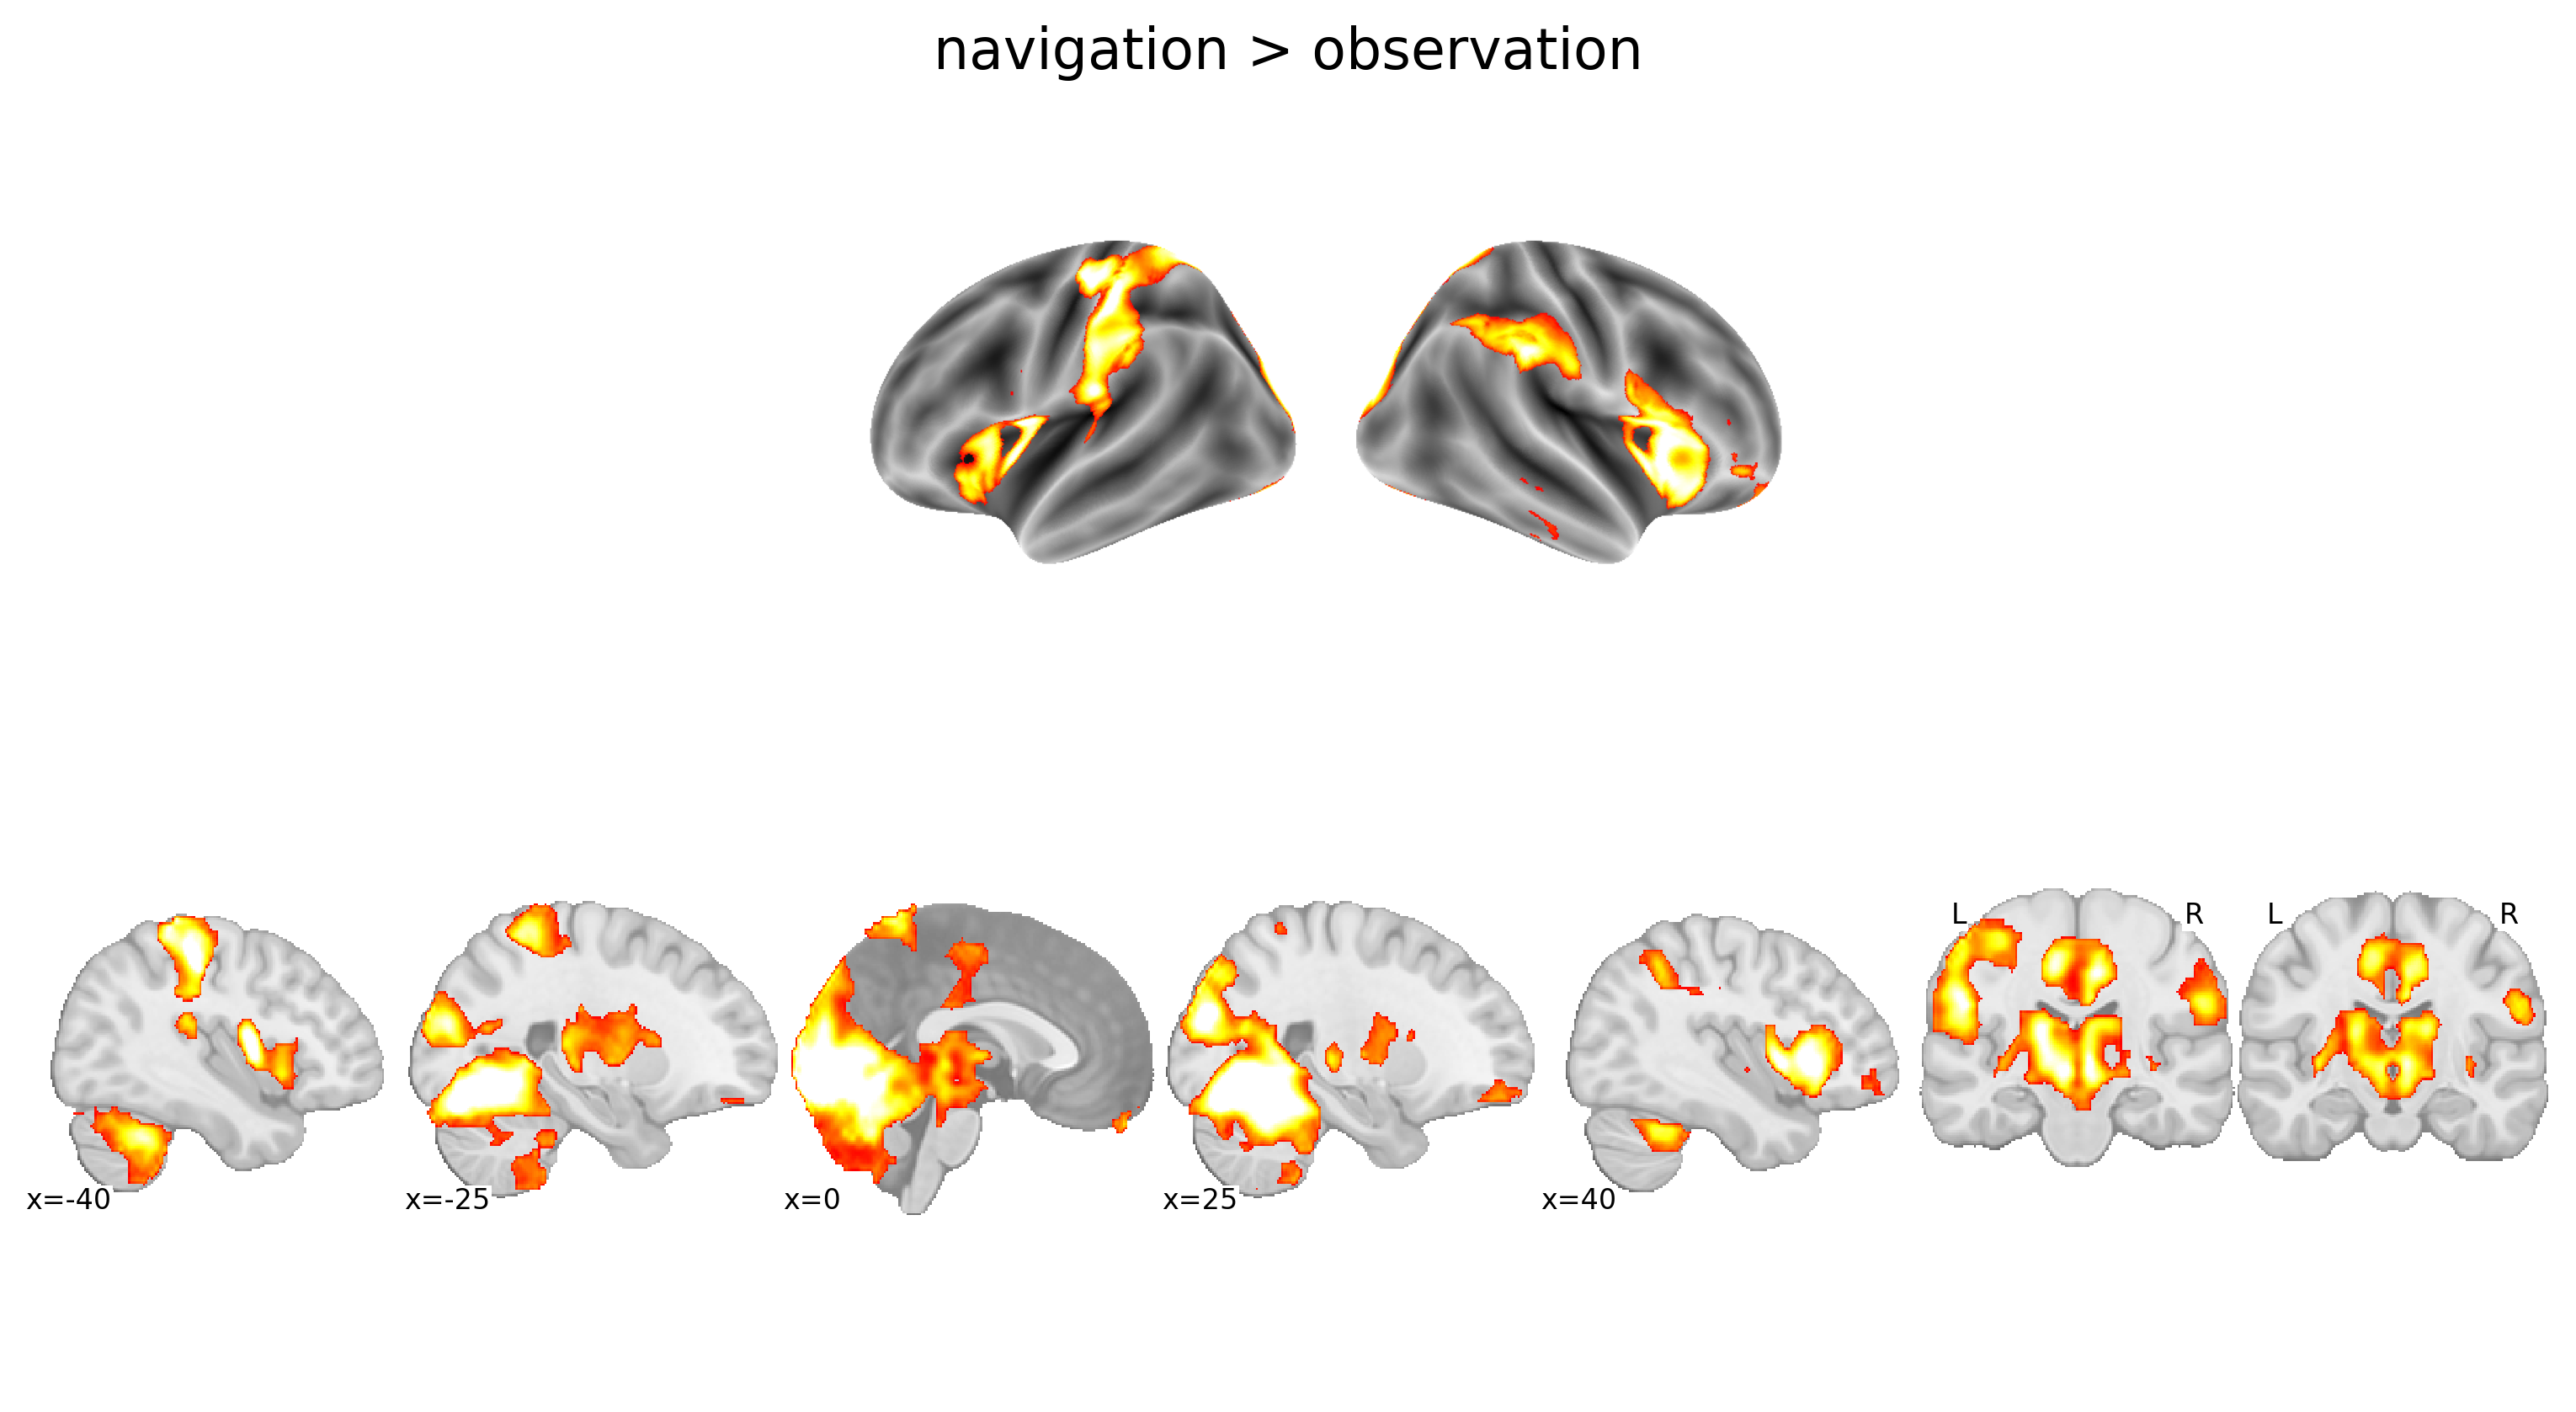

In [169]:
# create figure

fig = plt.figure(figsize=(10, 5.5), dpi=300)
#  rc('font', size=8)

# first row: surface plot

plot_upper = fig.add_subplot(2, 1, 1)
figure_surface = plt.imread("figure_surface_01.png")
plot_upper = plt.imshow(figure_surface)
plot_upper.axes.set_axis_off()

# second row, left:

plot_left = plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-40, -25, 0, 25, 40),
    display_mode="x",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
    annotate=False,
    figure=fig,
    axes=(0, 0, 0.75, 0.48),  # axes = (xmin, ymin, width, height)
)

plot_left.annotate(left_right=False, positions=True, size=8, scale_loc="center")

# second row, right:

plot_right = plotting.plot_stat_map(
    thresholded_map_pos,
    bg_img=template,
    cut_coords=(-20, -15),
    display_mode="y",
    threshold=threshold,
    vmax=10,
    black_bg=False,
    colorbar=False,
    annotate=False,
    figure=fig,
    axes=(0.75, 0, 0.25, 0.48),
)

plot_right.annotate(left_right=True, positions=False, size=8, scale_loc="center")

# set title

fig.suptitle(chosen_contrast, fontsize=16)

# save figure

fig.savefig("figure_complete_01.png", pad_inches=0, bbox_inches="tight")

## **C)** Glass brain plot for contrast `obervation > baseline * cumulative distance error (vm)`

### Define data and distance matrix

In [45]:
chosen_contrast = "obervation > baseline * cumulative distance error (vm)"


cmaps_dir = (
    data_dir
    + "/model_m1_contrasts_swratopup/"
    + contrast_dir_dict[chosen_contrast]
    + "-AllSessions"
)

print(f"data is stored in: {abspath(cmaps_dir)}")

cmaps = sorted(
    glob(
        f"{abspath(cmaps_dir)}/**/*.nii",
        recursive=True,
    )
)

# pprint(cmaps)
print(f"\nThere are {len(cmaps)} contrast maps")

n_subjects = len(cmaps)
subject_list = [f"sub-{i:02d}" for i in range(1, n_subjects + 1)]

data is stored in: /main/assignments/group/data_Wagner_NatComms_2022/model_m1_contrasts_swratopup/other-AllSessions

There are 59 contrast maps


In [46]:
# Intercept-only model, no groups, no 2nd level contrasts
design_matrix = pd.DataFrame(
    [1] * n_subjects, columns=["intercept"], index=subject_list
)

dist_err = pd.read_excel("data_Wagner_NatComms_2022/avgDistErr_20210408.xlsx")
dist_err["subjn"] = "sub-" + dist_err["subjn"].astype(str).str.zfill(2)
dist_err = dist_err.set_index("subjn")

design_matrix = design_matrix.merge(
    dist_err["mean"], left_index=True, right_index=True
).rename(columns={"mean": "distance_error"})

design_matrix.head()

,intercept,distance_error
sub-01,1,19.41951
sub-02,1,26.60407
sub-03,1,10.69242
sub-04,1,27.78675
sub-05,1,14.30383


<div class="alert alert-warning">How to correctly specify the interaction?</div>

The FDR=.001 threshold is 3.919


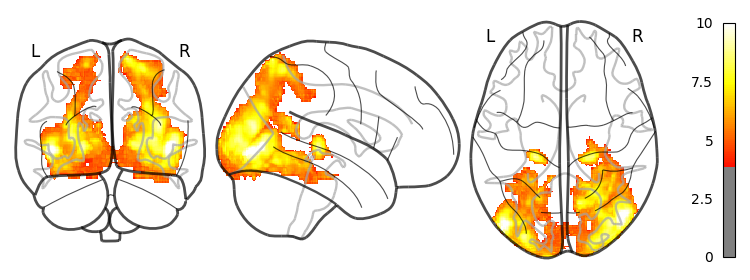

In [47]:
# Filter filepaths of cmaps to available data

def check_available(filepath, mat):
    number = re.findall("S[0-9][0-9]_", filepath)[0].replace("S", "").replace("_", "")
    res = "sub-" + number
    res = res in mat.index
    return res


cmaps_filtered = [cm for cm in cmaps if check_available(cm, design_matrix)]

second_level = SecondLevelModel(n_jobs=2)
second_level = second_level.fit(cmaps_filtered, design_matrix=design_matrix)

other_baseline = second_level.compute_contrast(
    second_level_contrast="intercept + distance_error",
    output_type="stat",
    second_level_stat_type="t",
)

thresholded_map, threshold = threshold_stats_img(
    other_baseline,
    alpha=0.001,
    height_control="fdr",
    cluster_threshold=80,
    two_sided=True,
)

print(f"The FDR=.001 threshold is {round(threshold, 3)}")


thresholded_map_pos = image.new_img_like(
    thresholded_map, np.clip(thresholded_map.get_fdata(), 0, None)
)

# scale up resolution to template
thresholded_map_pos = resample_to_img(thresholded_map_pos, template)


plotting.plot_glass_brain(
    thresholded_map_pos, threshold=threshold, colorbar=True, vmax=10, cmap="cold_hot"
)

# 2. Store objects

Save

In [48]:
pickle.dump(second_level, open("second_level.pkl", "wb"))
!ls ./

'Group assignment.ipynb'     multiplot_figure.png	    second_level.pkl
 data_Wagner_NatComms_2022   multiplot_figure_obs_nav.png


Load

In [49]:
secondlvl_pkl = pickle.load(open("second_level.pkl", "rb"))

secondlvl_pkl.design_matrix_.head()

,intercept,distance_error
sub-01,1,19.41951
sub-02,1,26.60407
sub-03,1,10.69242
sub-04,1,27.78675
sub-05,1,14.30383


As we have pickled the already fitted object, we can go ahead and evaluate some contrasts (without fitting the model again):

/usr/local/lib/python3.10/dist-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


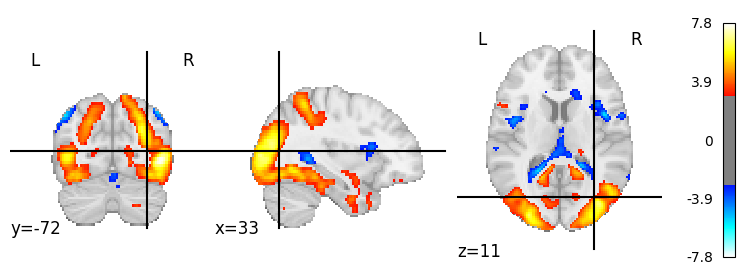

In [50]:
other_self_pkl = secondlvl_pkl.compute_contrast(
    second_level_contrast="intercept", output_type="z_score"
)

plotting.plot_stat_map(other_self_pkl, threshold=3)

# 3. ROI Analysis

Candidates:

* Entorhinal grid cells
* Hippocampus
* Medial temporal lobe

## Hippocampus

Pre-defined mask from www.neurovault.org

In [244]:
if os.path.exists("thresh_hippocampus_body_bothsides.nii.gz") == False:
    !wget "https://neurovault.org/media/images/2381/thresh_hippocampus_body_bothsides.nii.gz"
else:
    print("Mask already downloaded.")

Mask already downloaded.


In [245]:
hipp_mask = nib.load("thresh_hippocampus_body_bothsides.nii.gz")
print(f"shape of the mask: {hipp_mask.shape}")

shape of the mask: (157, 189, 156)


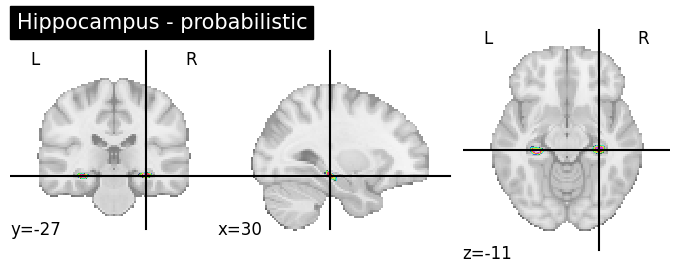

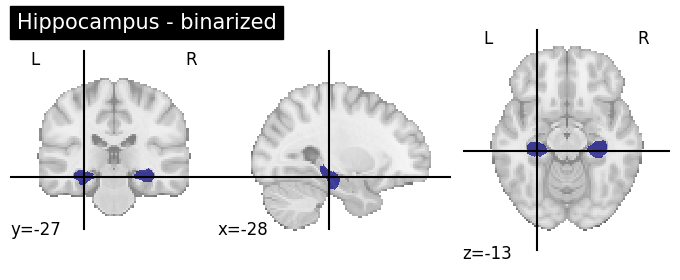

In [240]:
plotting.plot_roi(hipp_mask, title="Hippocampus - probabilistic")
plotting.plot_roi(image.binarize_img(hipp_mask, "10%"), title="Hippocampus - binarized")

## Extract ROI data from contrast maps

In [267]:
def extract_roi(cmaps, mask, threshold=None):
    """extract mean roi activation from contrast map

    Input:
    - List of contract maps
    - mask
    - threshold: only for probabilistic maps

    """

    if threshold != None:
        mask = image.binarize_img(mask, threshold)

    # instantiate numpy array to store results
    out = np.zeros(len(cmaps))

    # setup masker
    masker = NiftiMapsMasker(mask)

    # loop over subjects
    for i, cmap in enumerate(cmaps):
        print(f"processing subject {i+1} ...", end="")
        out[i] = masker.fit_transform(cmap)
        print("done")

    return out


hipp_means = extract_roi(cmaps, mask)

processing subject 1 ...done
processing subject 2 ...done
processing subject 3 ...done
processing subject 4 ...done
processing subject 5 ...done
processing subject 6 ...done
processing subject 7 ...done
processing subject 8 ...done
processing subject 9 ...done
processing subject 10 ...done
processing subject 11 ...done
processing subject 12 ...done
processing subject 13 ...done
processing subject 14 ...done
processing subject 15 ...done
processing subject 16 ...done
processing subject 17 ...done
processing subject 18 ...done
processing subject 19 ...done
processing subject 20 ...done
processing subject 21 ...done
processing subject 22 ...done
processing subject 23 ...done
processing subject 24 ...done
processing subject 25 ...done
processing subject 26 ...done
processing subject 27 ...done
processing subject 28 ...done
processing subject 29 ...done
processing subject 30 ...done
processing subject 31 ...done
processing subject 32 ...done
processing subject 33 ...done
processing subject 

In [268]:
pprint(hipp_means)

array([-1.54789622e+00,  1.57801577e+00,  1.82990025e-01, -2.02338387e+00,
        1.59701746e+00, -2.54042885e+00,  8.14291612e-01, -3.17655878e+00,
       -6.08403104e-01,  1.19629809e+00, -2.33430075e+00, -1.56648930e-01,
        3.44109786e-01, -2.60440000e+00, -8.77314574e-01, -6.79570571e+00,
       -4.96092090e+00, -8.11722355e+00, -2.86571145e-01, -1.17610277e+00,
       -2.40119696e+00,  1.12552190e+00, -2.42138613e-02,  1.10126487e+00,
       -5.72345263e+00,  8.12942254e-01,  3.28364760e+00, -1.25875548e+00,
        1.29154637e+00, -3.32870101e+00, -9.04881262e+00, -3.07465431e+00,
        2.29713884e+00, -6.40378736e+00, -2.66737981e+00, -1.03323398e+01,
        4.29692456e+00, -4.80130221e+00,  2.81409841e+00,  2.11690085e+00,
        1.09996960e+01, -6.04797818e-02, -2.85125445e+00,  9.33552649e-01,
        9.16590868e-01, -4.93151760e+00, -3.61957814e+00, -6.74583075e-01,
       -2.01622840e+00, -5.29777971e+00,  6.58940885e-01, -5.49267921e-02,
       -9.55189531e-01,  

<div class="alert alert-warning">Where do we go from there? Do we need a second ROI to contrast it with?</div>